In [1]:
import sys
sys.path.append("../")

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
%reload_ext autoreload
%autoreload 2

In [4]:
import os
import torch
from utils import *
from collections import defaultdict
import matplotlib.pyplot as plt
import time

#### Experiment Configs

In [5]:
root_path = "/scratch/saksham/data/freiburg_small/"
sequences = "sequences.txt"
img_wh = (640, 480)
N_importance = 64
N_samples = 64
use_disp = True
chunk = 1024*32*4

In [6]:
from datasets import dataset_dict
from datasets.llff import *

dataset = dataset_dict['llff_TUM'](
              root_path,
              start = 0,
              end = 30,
              split = "val",
              img_wh = img_wh,
              spheric_poses = False,
              val_num = 4
          )

val image is /scratch/saksham/data/freiburg_small/images/1305031455.159720.png


In [7]:
# take a sample from the validation set
index = 0
sample = dataset[index]
rays = sample['rays']
rays.shape

torch.Size([307200, 8])

#### Define Models

In [8]:
from models.nerf import Embedding, NeRF

In [11]:
# Embeds x to (x, sin(2^k x), cos(2^k x), ...) 
embedding_xyz = Embedding(3, 10)
embedding_dir = Embedding(3, 4)

# Encodes input (xyz+dir) to rgb+sigma (not ready to render yet)
nerf_coarse = NeRF()
nerf_fine = NeRF()

ckpt_path = "../ckpts/tum_desk_exp17/epoch=25.ckpt"

In [12]:
load_ckpt(nerf_coarse, ckpt_path, model_name='nerf_coarse')
load_ckpt(nerf_fine, ckpt_path, model_name='nerf_fine')

In [13]:
nerf_coarse.cuda().eval()
nerf_fine.cuda().eval();

In [14]:
models = {'coarse': nerf_coarse, 'fine': nerf_fine}
embeddings = {'xyz': embedding_xyz, 'dir': embedding_dir}

#### Rendering 

In [15]:
# rendering params
N_importance = 64 # number of fine samples per ray
N_samples = 64 # number of coarse samples per ray
use_disp = False # whether to sample in disparity space (inverse depth)
perturb = False # factor to perturb the sampling position on the ray (for coarse model only)
noise_std = 1.0  # factor to perturb the model's prediction of sigma
chunk = 1024*32*4
test_time = True
white_back = dataset.white_back

In [16]:
from models.rendering import *
from models.nerf import *

@torch.no_grad()
def f(rays):
    """Do batched inference on rays using chunk."""
    B = rays.shape[0]
    results = defaultdict(list)
    for i in range(0, B, chunk):
        rendered_ray_chunks = \
            render_rays(models,
                        embeddings,
                        rays[i:i+chunk],
                        N_samples,
                        use_disp,
                        0,
                        0,
                        N_importance,
                        chunk,
                        dataset.white_back,
                        test_time=False)

        for k, v in rendered_ray_chunks.items():
            results[k] += [v]

    for k, v in results.items():
        results[k] = torch.cat(v, 0)
    return results

In [17]:
sample = dataset[0]
rays = sample['rays'].cuda()

t = time.time()
results = f(rays)
torch.cuda.synchronize()
print(time.time()-t)

28.65086054801941


In [18]:
results['depth_fine'].shape

torch.Size([307200])

In [19]:
results['depth_coarse'].shape

torch.Size([307200])

In [20]:
def visualize_depth(depth, cmap=cv2.COLORMAP_JET, return_PIL = False, resize = False):
    """
    depth: (H, W)
    """
    x = depth.cpu().numpy()
    x = np.nan_to_num(x) # change nan to 0
#     mi = np.min(x) # get minimum depth
#     ma = np.max(x)
    mi = 0 # get minimum depth
    ma = 1
    x = (x-mi)/max(ma-mi, 1e-8) # normalize to 0~1
    x = (255*x).astype(np.uint8)
    x_ = Image.fromarray(cv2.applyColorMap(x, cmap))
    # resizing for visual aid on tensorboard
    if resize:
        x_ = x_.resize((640,480), resample = Image.NEAREST)
    if return_PIL:
        return x_
    x_ = T.ToTensor()(x_) # (3, H, W)
    return x_

PSNR 30.67772102355957


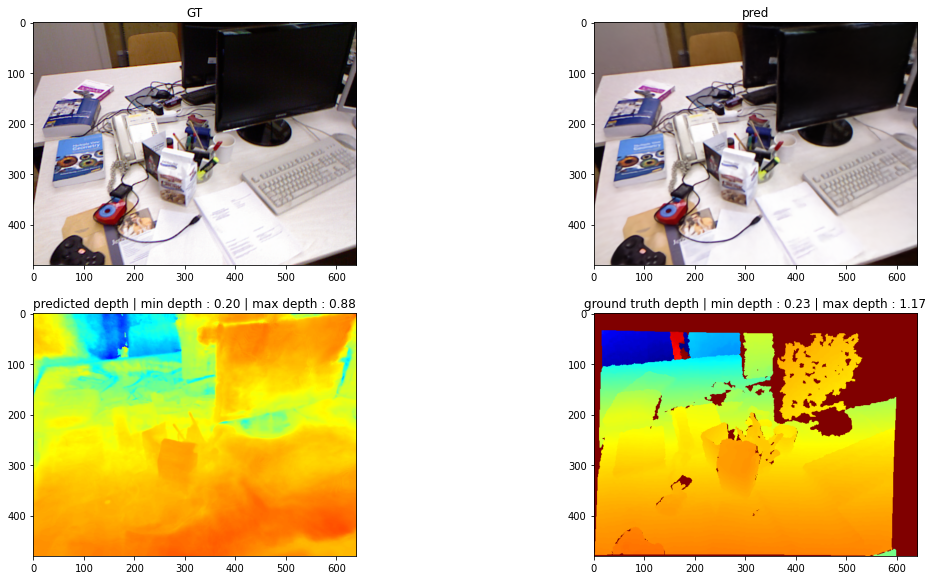

In [21]:
import metrics

img_gt = sample['rgbs'].view(img_wh[1], img_wh[0], 3)
depth_gt = sample['depths'].view(img_wh[1], img_wh[0])
img_pred = results['rgb_fine'].view(img_wh[1], img_wh[0], 3).cpu().numpy()
alpha_pred = results['opacity_fine'].view(img_wh[1], img_wh[0]).cpu().numpy()
depth_gt = (sample['depths'].view(img_wh[1], img_wh[0]))
depth_pred = results['depth_fine'].view(img_wh[1], img_wh[0])

print('PSNR', metrics.psnr(img_gt, img_pred).item())

plt.subplots(figsize=(15, 8))
plt.tight_layout()
plt.subplot(221)
plt.title('GT')
plt.imshow(img_gt)
plt.subplot(222)
plt.title('pred')
plt.imshow(img_pred)
plt.subplot(223)
plt.title('predicted depth | min depth : {0:.2f} | max depth : {1:.2f}'.format(depth_pred.min(), depth_pred.max()))
plt.imshow(visualize_depth(depth_pred).permute(1,2,0))
plt.subplot(224)
plt.title('ground truth depth | min depth : {0:.2f} | max depth : {1:.2f}'.format(depth_gt[depth_gt>0].min(), depth_gt.max()))
plt.imshow(visualize_depth(depth_gt).permute(1,2,0))
plt.show()

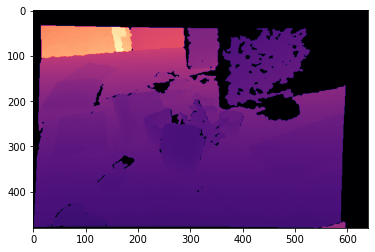

In [38]:
plt.imshow(depth_gt.detach().cpu().numpy(),cmap='magma',  aspect='auto')

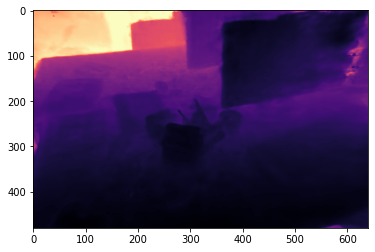

In [37]:
plt.imshow(depth_pred.detach().cpu().numpy(),cmap='magma',  aspect='auto')

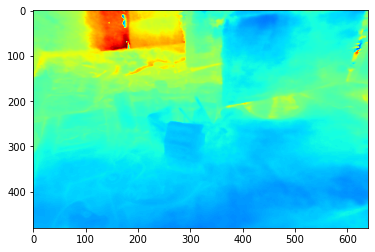

In [26]:
depth_pred = results['depth_coarse'].view(img_wh[1], img_wh[0])
plt.imshow(depth_pred.detach().cpu().numpy(),cmap='jet', vmin=0, aspect='auto')